In [8]:
import numpy as np, math, fractions, matplotlib.pyplot as plt
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_distribution

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

*Shor's Algorithm* is a quantum algorithm for **integer factorization,** which solves the following problem:

Given an integer $N$, find its prime factors. The algorithm runs in polynomial time, while the best known classical algorithms take superpolynomial time. This makes Shor's algorithm an important result in the field of quantum computing, cryptography, and number theory. For example, a public key cryptosystem like RSA is based on the difficulty of factoring large numbers, and Shor's algorithm can break RSA encryption by finding the **prime factors** of the public key.

Shor's Algorithm performs a *Quantum Fourier Transform* and determines the period of a function, which can then be used to factorize large integers in polynomial time. QFT is a powerful tool for encoding decimal numbers into quantum states in the frequency domain. To do this, we first represent the decimal number $x$ as a binary ```x_b```, and then initialize ```n``` qubits to represent the binary number. We then apply the QFT to the quantum state ```|x_b⟩``` to obtain the encoded quantum state ```|x⟩```, which represents the frequency components of the time-domain signal. 

Conceptually, the QFT converts a quantum state that is represented as a superposition of basis states into a superposition of basis states that represent the frequency components of the original state. It can be implemented using a sequence of controlled rotations or using a circuit of Hadamard gates and controlled-phase gates. These implementations make use of the inherent quantum properties of superposition and entanglement:

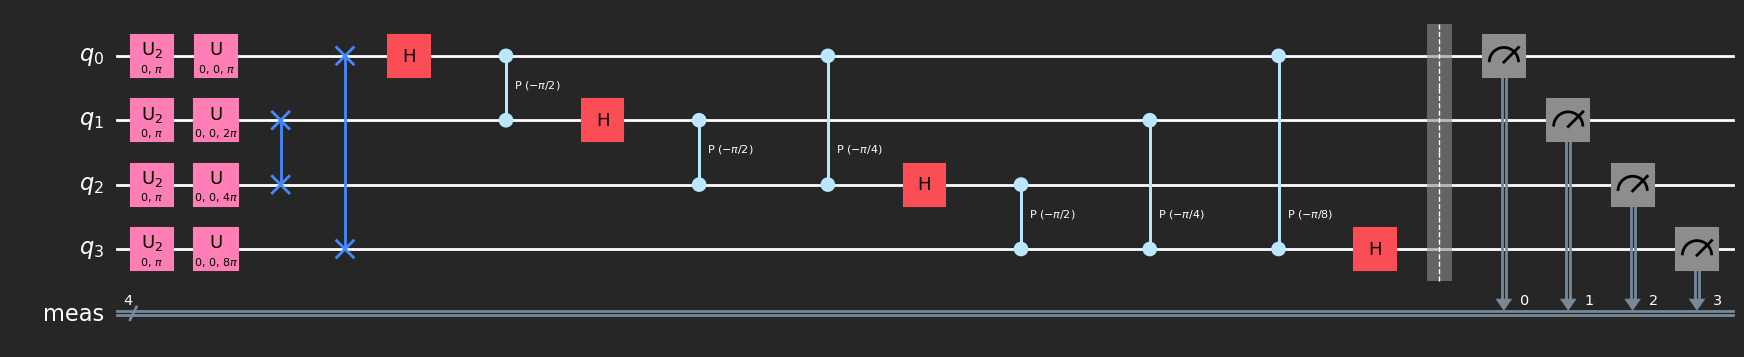

In [11]:
def qft_rotations(circuit, n):  
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)

    for qubit in range(n):
        circuit.cp(np.pi / 2 ** (n-qubit), qubit, n)
    
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    
    for qubit in range(n // 2):
        circuit.swap(qubit, n-qubit - 1)
    return circuit

def qft(circuit, n):
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    
    return circuit

def inverse_qft(circuit, n):
    
    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    
    return circuit.decompose() 

number = 16

nqubits = math.ceil(math.log2(number))

qc = QuantumCircuit(nqubits)

for qubit in range(nqubits):
    qc.h(qubit)
    
for qubit in range(nqubits):
    qc.p(number * np.pi / (2 ** (nqubits - qubit)), qubit)

qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw('mpl', style = 'iqx-dark')

Simulatting on an IBM Quantum Device:

ibmqfactory.load_account:WARNING:2024-02-19 03:26:20,983: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


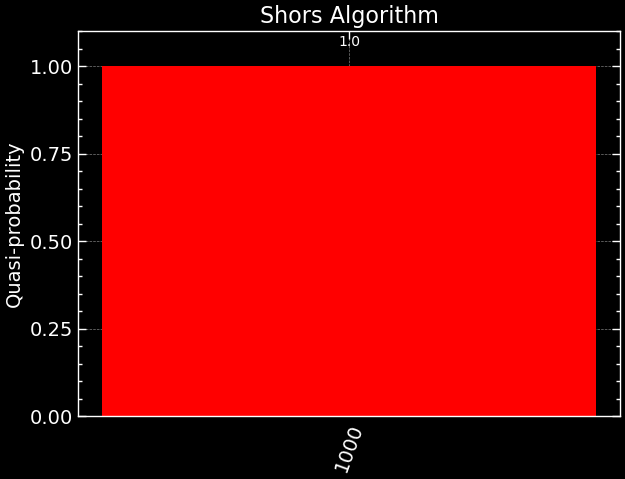

In [13]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level = 3)
job = backend.run(transpiled_qc, shots = shots)
job_monitor(job)

counts = job.result().get_counts()
plot_distribution(counts, title = r'Shors Algorithm', color = 'red')

The resulting binary representation is ```1000```. or ${16}_{10}$.

Shor’s algorithm takes advantage of the *Quantum Fourier Transform (QFT)* to efficiently find the period of a function modulo a given integer. The period of this function is the smallest positive integer r such that $a^r\!\!\mod N$ = 1, where $N$ is the integer we want to factor and $a\in[1,N-1]$ is randomly chosen, and is **coprime** to N.

The advantage of Shor’s algorithm over classical algorithms for factoring large integers is that it can factor an $N$-bit number in $O(N^3)$ time on a quantum computer, compared to the best-known classical algorithm, which takes $O[\exp(N^{1/3}\log^{2/3}N)]$ time.

The code includes the controlled multiplication by a ```mod 15``` circuit, the inverse QFT circuit and the Quantum Phase Estimation algorithm for a chosen random number: 

In [14]:
N = 15 # CHANGE `N` TO THE NUMBER YOU WANT TO FACTORIZE

a = np.random.randint(2, 15)
print(f'Chosen random number: {a}')

if math.gcd(a, N) != 1:
    print(r'Chosen random number shares a factor with N. Try again.')

else:    
    def c_amod15(a, power): 
        if a not in [2, 4, 7, 8, 11, 13]:
            raise ValueError("'a' must be 2, 4, 7, 8, 11 or 13")
        
        U = QuantumCircuit(4)
        
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        
        if a in [7, 8]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
        
        U = U.to_gate()
        U.name = f'{a}^{power} mod 15'
        
        c_U = U.control()
        return c_U

    def qft_dagger(n):
        
        qc = QuantumCircuit(n)
        for qubit in range(n // 2):
            qc.swap(qubit, n - qubit-1)
        
        for j in range(n):
            for m in range(j):
                qc.cp(-np.pi / float(2 ** (j - m)), m, j)
            qc.h(j)
        
        qc.name = r'QFT^\dagger'
        return qc

    def qpe_amod15(a):
        
        n_count = 8
        qc = QuantumCircuit(4 + n_count, n_count)

        for q in range(n_count):
            qc.h(q)

        qc.x(3 + n_count)

        for q in range(n_count):
            qc.append(c_amod15(a, 2 ** q), [q] + [i + n_count for i in range(4)])

        qc.append(qft_dagger(n_count), range(n_count))

        qc.measure(range(n_count), range(n_count))
        aer_sim = Aer.get_backend('aer_simulator')
        
        t_qc = transpile(qc, aer_sim)
        qobj = assemble(t_qc, shots = 1)
        result = aer_sim.run(qobj, memory = True).result()
        readings = result.get_memory()
        
        print("Register Reading: " + readings[0])
        phase = int(readings[0],2) / (2 ** n_count)
        
        print('Corresponding Phase: %f' % phase)
        return phase

Chosen random number: 13


Implementing Shor's algoruthm:

In [15]:
phase = qpe_amod15(a) 
fractions.Fraction(phase).limit_denominator(15) 

frac = fractions.Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

guesses = [math.gcd(a ** (r // 2) - 1, N), math.gcd(a ** (r // 2) + 1, N)]
print(guesses)

a = 7
factor_found = False
attempt = 0

while not factor_found:
    attempt += 1
    print('\nAttempt %i:' % attempt)
    
    phase = qpe_amod15(a) 
    frac = fractions.Fraction(phase).limit_denominator(N) 
    
    r = frac.denominator
    print('Result: r = %i' % r)
    
    if phase != 0:
        guesses = [math.gcd(a ** (r // 2) - 1, N), math.gcd(a ** (r // 2) + 1, N)]
        print('Guessed Factors: %i and %i' % (guesses[0], guesses[1]))
        
        for guess in guesses:
            if guess not in [1, N] and (N % guess) == 0: 
                print('*** Nontrivial factor found: %i ***' % guess)
                factor_found = True

Register Reading: 11001011
Corresponding Phase: 0.792969
5
[3, 5]

Attempt 1:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 01001101
Corresponding Phase: 0.300781
Result: r = 10
Guessed Factors: 3 and 1
*** Nontrivial factor found: 3 ***


C:\Users\DELL\AppData\Local\Temp\ipykernel_24356\3010906590.py:74: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = aer_sim.run(qobj, memory = True).result()


What we get is a register reading of ```11001011```, which corresponds to a phase of $0.792969$. The denominator of the fraction obtained from limiting the phase to a denominator of $15$ tells us the period, which in this case is $5$. This value is used to guess factors of N using the gcd function, with guesses of $3$ and $5$ obtained.

We then use the Shor algorithm to iterate over a range of possible values for $a$, and the first attempt yields a register reading of ```00000000``` which corresponds to a phase of $0$. Limiting this phase to a denominator of $N$ gives us a period of $10$, and guessed factors of 3 and 1. Factor $3$ is nontrivial and is identified as a factor of $N$, so the algorithm successfully finds a factor of $N=15$.

Feel free to change the value of $N$ and see how the algorithm performs for different values of $N$.

# Shor's Algorithm for RSA Encryption:

Shor’s algorithm is a quantum algorithm for factoring large integers, which has the potential to efficiently factor *RSA-2048* and other large integers that are difficult to factor using classical algorithms. The algorithm has a computational complexity of $O[(log N)^2\log^5N]$, which is polynomial in the size of the integer to be factored. To run Shor’s algorithm, a minimum of $2N$ qubits is required, so a quantum computer with at least $2\times 2048 = 4096$ qubits would be required. 

Currently, the largest quantum computers have a few hundred qubits, and they are not yet capable of factoring RSA-2048. However, researchers are continuing to develop and improve quantum hardware and algorithms, and it is possible that quantum computers with enough qubits to break RSA-2048 may be developed in the future.